In [1]:
import pandas as pd
import numpy as np

df_heart = pd.read_csv('../data/heart_disease_processed.csv')
df_heart_num = pd.read_csv('../data/heart_disease_processed_numeric_sc.csv')

# convert appropriate features to categorical
for col in df_heart.select_dtypes(include='object').columns:
    df_heart[col] = df_heart[col].astype('category')

X = df_heart_num.drop(columns=['heart_disease']).to_numpy()
y = df_heart_num['heart_disease'].to_numpy()

In [2]:
prevalence = np.mean(y)
majority = np.max([prevalence, 1 - prevalence])

## Penalized

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate, KFold, cross_val_score
from sklearn.metrics import accuracy_score


model_elastic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    random_state=42,
    max_iter=10000,
    verbose=False,
)

# model_elastic.fit(X_complete, y_complete)

 # use cross-validation to estimate performance
cv_elastic = cross_validate(
    model_elastic,
    X,
    y,
    cv=5,
    scoring='accuracy',
)

In [4]:
pd.DataFrame(cv_elastic).to_csv('../ml/data/elasticnet-py-results.csv', index=False)

## Tree/Boosting

In [5]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

model_boost = LGBMClassifier(
    n_estimators=1000,
    learning_rate=1e-3,
    max_depth = 5,
    verbose = -1,
    random_state=42,
)

cv_boost = cross_validate(
    model_boost,
    df_heart.drop(columns='heart_disease'),
    df_heart_num['heart_disease'],
    cv=5,
    scoring='accuracy',
)

In [6]:
pd.DataFrame(cv_boost).to_csv('../ml/data/boost-py-results.csv', index=False)

## Deep

In [7]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(
    hidden_layer_sizes=(200, 200, 200),  
    learning_rate='adaptive',
    learning_rate_init=0.001,
    shuffle=True,
    random_state=123,
    warm_start=True,
    nesterovs_momentum=True,
    validation_fraction= .2,
    verbose=False,
)

# with the above settings, this will take a few seconds
cv_mlp = cross_validate(
  model_mlp, 
  X, 
  y, 
  cv=5
) 


In [8]:
pd.DataFrame(cv_mlp).to_csv('../ml/data/deep-py-results.csv', index=False)

In [9]:
cv_mlp = pd.read_csv('../ml/data/deep-py-results.csv')

print(
    'Training accuracy: ',
    np.round(np.mean(cv_mlp['test_score']), 3),
    '\nBaseline Prevalence: ',
    np.round(prevalence, 3),
)

Training accuracy:  0.818 
Baseline Prevalence:  0.461


## Tuned

In [16]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_heart.drop(columns='heart_disease'), 
    df_heart_num['heart_disease'],
    test_size=0.2,
    random_state=42
)

model_boost = LGBMClassifier(
    verbose = -1
)

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [1e-3, 1e-2, 1e-1],
    'max_depth': [3, 5, 7, 9],
    'min_child_samples': [1, 5, 10],
}

# this will take a few seconds
cv_boost_tune = RandomizedSearchCV(
    model_boost, 
    param_grid, 
    n_iter = 10,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

cv_boost_tune.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(verbose=-1), n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_samples': [1, 5, 10],
                                        'n_estimators': [500, 1000]},
                   scoring='accuracy')

In [11]:
import joblib

#save your model or results
joblib.dump(cv_boost_tune.best_estimator_, '../ml/data/tune-boost-py-model.pkl')

test_predictions = cv_boost_tune.predict(X_test)

In [12]:
pd.DataFrame(cv_boost_tune.cv_results_).to_csv('../ml/data/tune-boost-py-results.csv', index=False)
pd.DataFrame(test_predictions).to_csv('../ml/data/tune-boost-py-predictions.csv', index=False)

## Importance

In [20]:
cv_boost_tune.best_estimator_.feature_importances_

array([526, 106,  16, 364, 513,  94, 106, 437,  53, 322,  91, 225, 156],
      dtype=int32)

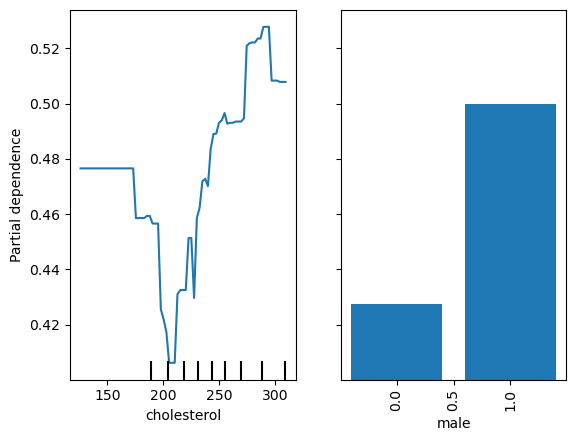

In [21]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    cv_boost_tune, 
    df_heart.drop(columns='heart_disease'), 
    features=['cholesterol', 'male'], 
    categorical_features=['male'], 
    percentiles=(0, .9),
    grid_resolution=75
)